<a href="https://colab.research.google.com/github/ranjan2829/Transformer-from-scratch/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchviz


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 673.4 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=4f172d05f91d93e69fc5fa8ffca137829a678055fe092f4c7c211a22d166b554
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Epoch: 1, Loss: 8.686049461364746, Accuracy: 0.05%
Epoch: 2, Loss: 8.554169654846191, Accuracy: 0.08%
Epoch: 3, Loss: 8.4827299118042, Accuracy: 0.08%
Epoch: 4, Loss: 8.432656288146973, Accuracy: 0.11%
Epoch: 5, Loss: 8.38684368133545, Accuracy: 0.13%
Epoch: 6, Loss: 8.322428703308105, Accuracy: 0.22%
Epoch: 7, Loss: 8.248672485351562, Accuracy: 0.55%
Epoch: 8, Loss: 8.15955638885498, Accuracy: 0.92%
Epoch: 9, Loss: 8.079401969909668, Accuracy: 1.18%
Epoch: 10, Loss: 8.005767822265625, Accuracy: 1.40%
Epoch: 11, Loss: 7.9267659187316895, Accuracy: 2.24%
Epoch: 12, Loss: 7.84762716293335, Accuracy: 3.12%
Epoch: 13, Loss: 7.761881351470947, Accuracy: 4.51%
Epoch: 14, Loss: 7.68185567855835, Accuracy: 6.12%
Epoch: 15, Loss: 7.596157073974609, Accuracy: 8.27%
Epoch: 16, Loss: 7.515481472015381, Accuracy: 10.83%
Epoch: 17, Loss: 7.428794860839844, Accuracy: 13.64%
Epoch: 18, Loss: 7.3520331382751465, Accuracy: 16.10%
Epoch: 19, Loss: 7.26386833190918, Accuracy: 20.09%
Epoch: 20, Loss: 7.190

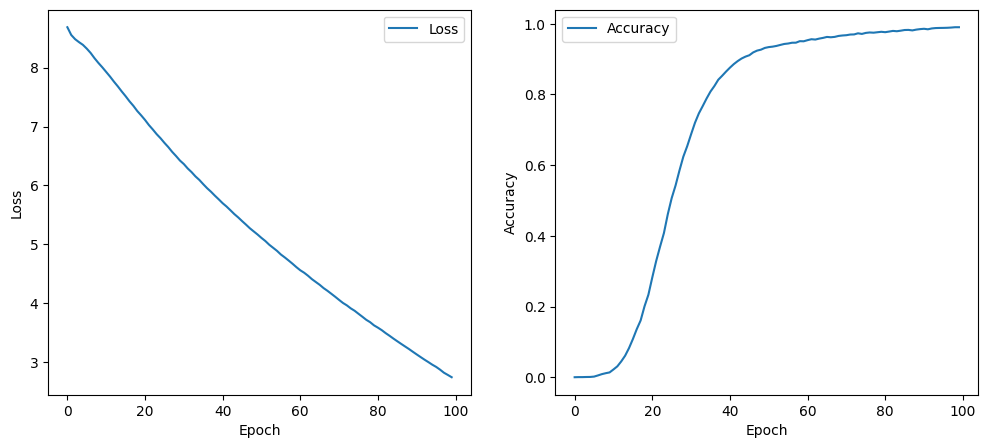

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.762307 to fit


'transformer_computation_graph.png'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from torchviz import make_dot

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        attention_probs = torch.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attention_output))
        return output

class PositionalWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionalWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionalWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionalWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn))
        attn = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn))
        ff = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff))
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.encoder_layers = nn.ModuleList([Encoder(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([Decoder(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

losses = []
accuracies = []

def calculate_accuracy(model, src_data, tgt_data):
    model.eval()
    with torch.no_grad():
        output = model(src_data, tgt_data[:, :-1])
        output_flat = output.contiguous().view(-1, tgt_vocab_size)
        predictions = output_flat.argmax(dim=1)
        targets = tgt_data[:, 1:].contiguous().view(-1)
        non_pad_elements = targets != 0  # Ignore padding
        correct_predictions = predictions[non_pad_elements] == targets[non_pad_elements]
        accuracy = correct_predictions.sum().item() / non_pad_elements.sum().item()
    model.train()
    return accuracy

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracy = calculate_accuracy(transformer, src_data, tgt_data)
    accuracies.append(accuracy)
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%")

# Save the model
torch.save(transformer.state_dict(), 'transformer_model.pth')

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Visualize the computation graph
sample_src = torch.randint(1, src_vocab_size, (1, max_seq_length))
sample_tgt = torch.randint(1, tgt_vocab_size, (1, max_seq_length))
output = transformer(sample_src, sample_tgt[:, :-1])
make_dot(output, params=dict(transformer.named_parameters())).render("transformer_computation_graph", format="png")
